In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import os
os.chdir('drive/My Drive/colab_notebooks/pose_estimation')

In [3]:
!nvidia-smi

Mon Jan 13 22:42:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Imports

In [0]:
import json
import requests
import zipfile
import torch
import os
import numpy as np
from torch.utils import data
from torchvision import transforms
from PIL import Image
from io import BytesIO
from collections import OrderedDict
from generate_cmap_paf import generate_cmap, generate_paf, annotations_to_connections, annotations_to_peaks

## Configs

In [0]:
from pose_datasets import FootOnlyConfig, BodyAndFeetConfig, HandConfig

## Datasets


In [0]:
from pose_datasets import FootPoseDataset, HandPoseDataset

## Transforms

In [0]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return torch.clamp(tensor + torch.randn(tensor.size()) * self.std + self.mean, 0, 1)

    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class RandomShiftImageAndAnnotations(object):
    """ shift image uniformly while keeping keypoints in image boundaries """

    def __call__(self, image, keypoints):     
        # find bounding box of keypoints  
        visible_keypoints = keypoints[keypoints[:, 2] != 0]
        xmin = np.min(visible_keypoints[:, 0])
        xmax = np.max(visible_keypoints[:, 0])
        ymin = np.min(visible_keypoints[:, 1])
        ymax = np.max(visible_keypoints[:, 1])

        # generate a random x and y shift
        x_shift = np.random.uniform(np.max(-xmin, 0), np.min(1.0 - xmax, 1.0))
        y_shift = np.random.uniform(np.max(-ymin, 0), np.min(1.0 - ymax, 1.0))

        # shift keypoints
        keypoints[:, 0] += x_shift
        keypoints[:, 1] += y_shift

        img_width = image.shape[1]
        img_height = image.shape[0]

        x_shift_pix = x_shift * img_width
        y_shift_pix = y_shift * img_height

        # slice of source image
        src_x_slice = slice(max(0, x_shift_pix), min(img_width, img_width + x_shift_pix))
        src_y_slice = slice(max(0, y_shift_pix), min(img_height, img_height + y_shift_pix))

        # slice of destination image
        dest_x_slice = slice(max(0, -x_shift_pix), min(img_width, img_width - x_shift_pix))
        dest_y_slice = slice(max(0, -y_shift_pix), min(img_height, img_height - y_shift_pix))

        # shift image
        new_img = torch.zeros_like(image)
        new_img[:, dest_x_slice, dest_y_slice] = image[:, src_x_slice, src_y_slice]

        return new_img, keypoints

class CropAndRelabel(object):
    def __init__(self, xmin, xmax, ymin, ymax):
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        
    def __call__(self, image, annotations):
        width, height = image.size
        annotations[:, 0] += self.xmin
        annotations[:, 1] += self.ymin
        image_cropped = image.crop((self.xmin * width, self.ymin * height, self.xmax * width, self.ymax * height))
        image_cropped = image_cropped.resize((width, height))
        return image_cropped, annotations


In [0]:
def init_model_to_transfer_learning(pretrained_model, num_parts, num_links, num_upsample=3):
    """
    1. Disable backpropagation for the backbone
    2. Initialze the pretrained model by leaving the backbone's weights unchanged
    and resetting weights and output shape of the the paf and cmap extractors
    """

    # disable backpropagation for the backbone
    # for param in pretrained_model[0].parameters():
    #     param.requires_grad = False

    # # # disable batch normalization for the backbone
    # for m in pretrained_model[0].modules():
    #     if isinstance(m, torch.nn.BatchNorm2d):
    #         m.eval()

    feature_channels = 512
    new_cmap_channels = num_parts
    new_paf_channels = 2 * num_links
    upsample_channels = 256
    num_flat = 0

    # initialize new cmap and paf extractor
    new_cmap_paf_layer = CmapPafHeadAttention(feature_channels, new_cmap_channels, new_paf_channels, upsample_channels, num_upsample=num_upsample, num_flat=num_flat)

    # put the new extractor in the model instead of the old pretrained one
    pretrained_model[1] = new_cmap_paf_layer
    

## Training

In [0]:
import time
import copy

def train_model(model, criterion, optimizer, train_only=False, metric=None, scheduler=None, stdev_scheduler=None, window_scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('Inf')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        phases = ['train'] if train_only else ['train', 'val']

        # Each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # schedule heatmap standard deviation
            if stdev_scheduler is not None:
                new_stdev = stdev_scheduler(epoch)
                print('Setting %s dataset stdev to %s' % (phase, new_stdev))
                dataloaders[phase].dataset.set_stdev(new_stdev)

            # schedule heatmap window size
            if window_scheduler is not None:
                new_window = window_scheduler(epoch)
                print('Setting %s dataset window to %s' % (phase, new_window))
                dataloaders[phase].dataset.set_window(new_window)

            running_loss = 0.0
            running_corrects = 0

            sample_count = 0
            # Iterate over data.
            for inputs, cmaps, pafs in dataloaders[phase]:
                inputs = inputs.to(device)
                cmaps = cmaps.to(device)
                pafs = pafs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    cmap_loss = criterion(outputs[0], cmaps)
                    paf_loss = criterion(outputs[1], pafs)
                    cmap_metric = metric(outputs[0], cmaps)
                    paf_metric = metric(outputs[1], pafs)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        cmap_loss.backward(retain_graph=True)
                        paf_loss.backward()
                        optimizer.step()

                    sample_count += inputs.size(0)
                    if sample_count % (inputs.size(0) * 4) == 0:
                        status_line = '{}, after {} samples, batch cmap loss: {:.6f}, batch paf loss: {:.6f}'.format(phase, sample_count, cmap_loss, paf_loss)
                        if metric is not None:
                            status_line += ', batch cmap metric: {:.6f}, batch paf metric: {:.6f}'.format(cmap_metric, paf_metric)

                        print(status_line)


                # measure running loss as the average between cmap and paf loss
                running_loss += cmap_loss.item() + paf_loss.item() * inputs.size(0) / 2.0

            if scheduler is not None and phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / sample_count

            print('{} Loss: {:.6f}'.format(
                phase, epoch_loss))

            # deep copy the model
            eval_phase = 'train' if train_only else 'val'
            if phase == eval_phase and epoch_loss < best_loss:
                print('Updating best model weights')
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:6f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def sum_of_squared_errors(output, target):
    loss = torch.sum((output - target)**2) / output.shape[0]
    return loss

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
import importlib
from torchvision import transforms

data_tf = CropAndRelabel(0.25, 0.75, 0.25, 0.75)

train_dataset = HandPoseDataset('datasets/hand_pose/dataset_min_big_only.pkl', config=HandConfig(), transform=transforms.Compose([
                                                                        #    transforms.Resize((224, 224)),
                                                                           transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                                                                           transforms.ToTensor(),
                                                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                                           ]))
val_dataset = HandPoseDataset('datasets/hand_pose/dataset_min_big_only.pkl', config=HandConfig(), transform=transforms.Compose([
                                                                        #    transforms.Resize((224, 224)),
                                                                           transforms.ToTensor(),
                                                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                                           ]))

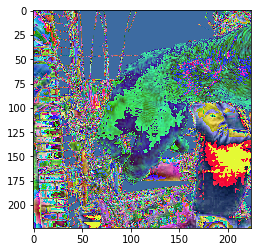

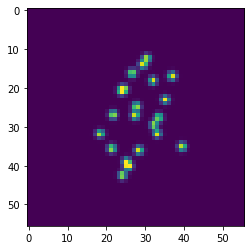

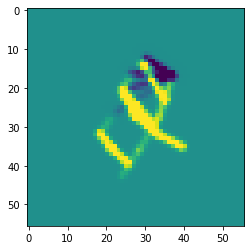

In [13]:
import matplotlib.pyplot as plt
train_dataset.set_stdev(1.0)
img, cmap, paf = train_dataset[444]
pil_tf = transforms.ToPILImage()
plt.imshow(pil_tf(img))
plt.show()
plt.imshow(torch.clamp(torch.sum(cmap, axis=0), 0, 1))
plt.show()
plt.imshow(torch.clamp(torch.sum(paf, axis=0), -1, 1))
plt.show()

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

nsamples = len(train_dataset)
train_val_split = nsamples - 512

sample_permutation = torch.randperm(nsamples)
train_range = list(range(train_val_split))
val_range = list(range(train_val_split, nsamples))

train_sampler = SubsetRandomSampler(sample_permutation[train_range])
val_sampler = SubsetRandomSampler(sample_permutation[val_range])

dataloaders = {
    'train': data.DataLoader(train_dataset, batch_size=32, num_workers=4, sampler=train_sampler),
    'val': data.DataLoader(val_dataset, batch_size=32, num_workers=4, sampler=val_sampler)
}
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

In [0]:
from common import *
from resnet import resnet18_baseline_att, resnet34_baseline_att
from torch.optim import lr_scheduler

# load the pre-trained model for COCO annotations
model = resnet18_baseline_att(18, 2 * 21).to(device)
model_weights_path = 'resnet18_baseline_att_224x224_A_epoch_249.pth'
#model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device)))

In [0]:
init_model_to_transfer_learning(model, train_dataset.config.num_parts, train_dataset.config.num_links)

In [0]:
criterion = torch.nn.MSELoss()
metric = torch.nn.MSELoss()

optimizer = torch.optim.RMSprop(
    [
        {"params": model[0].parameters(), "lr": 1e-3},
        {"params": model[1].parameters(), "lr": 1e-3},
    ],
    lr=1e-3,
)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [34]:
num_epochs = 10
model = train_model(model.to(device), criterion, optimizer, metric=metric, num_epochs=num_epochs, train_only=False,
                    scheduler=None, stdev_scheduler=lambda ep: max((7 - ep) / 2 + 2.0, 2.0))

Epoch 0/9
----------
Setting train dataset stdev to 5.5
train, after 128 samples, batch cmap loss: 0.018048, batch paf loss: 0.085203, batch cmap metric: 0.018048, batch paf metric: 0.085203
train, after 256 samples, batch cmap loss: 0.009255, batch paf loss: 0.019841, batch cmap metric: 0.009255, batch paf metric: 0.019841
train, after 384 samples, batch cmap loss: 0.008471, batch paf loss: 0.016500, batch cmap metric: 0.008471, batch paf metric: 0.016500
train, after 512 samples, batch cmap loss: 0.008269, batch paf loss: 0.015970, batch cmap metric: 0.008269, batch paf metric: 0.015970
train, after 640 samples, batch cmap loss: 0.008186, batch paf loss: 0.016401, batch cmap metric: 0.008186, batch paf metric: 0.016401
train, after 768 samples, batch cmap loss: 0.008096, batch paf loss: 0.016037, batch cmap metric: 0.008096, batch paf metric: 0.016037
train, after 896 samples, batch cmap loss: 0.008042, batch paf loss: 0.015391, batch cmap metric: 0.008042, batch paf metric: 0.015391

In [0]:
train_dataset_unnormed = HandPoseDataset('datasets/hand_pose/dataset_min_big_only.pkl', config=HandConfig(), transform=transforms.Compose([
                                                                        #    transforms.Resize((224, 224)),
                                                                           transforms.ToTensor(),
                                                                           ]))

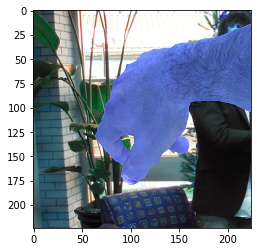

torch.Size([21, 56, 56])


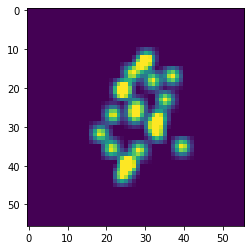

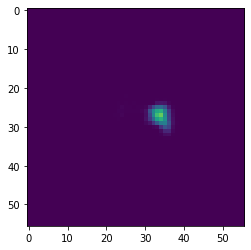

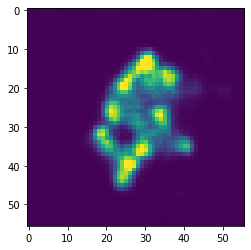

In [47]:
import matplotlib.pyplot as plt

ind = 0
img_ind = 444
# img_mean_inv = torch.Tensor([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
# img_std_inv = torch.Tensor([0.229, 0.224, 0.225]).reshape(-1, 1, 1)
# img_if = img * img_std_inv ** 2 + img_mean_inv
img_orig, cmap, paf = train_dataset_unnormed[img_ind]
tf = transforms.ToPILImage()
plt.imshow(tf(img_orig))
plt.show()

print(cmap.shape)

img, cmap, paf = train_dataset[img_ind]
plt.imshow(torch.sum(cmap, axis=0), vmin=0, vmax=1)
plt.show()

cmap_inf, paf_inf = model(img.reshape(1, *img.shape).to(device))
cmap_inf = cmap_inf.detach().cpu()
paf_inf = paf_inf.detach().cpu()
plt.imshow(cmap_inf[0, 1], vmin=0, vmax=1.0)
plt.show()
plt.imshow(torch.sum(cmap_inf[0], axis=0), vmin=0, vmax=1.0)
plt.show()
#cmap_ae = torch.sum(torch.abs(cmap_inf[0, ind] - cmap[ind]))
#print(torch.max(cmap[ind]))
#print(torch.max(cmap_inf[0][ind]))
#print(cmap_ae)

In [0]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model[0].resnet.register_forward_hook(get_activation('0.resnet.layer4.1.conv2.weight'))
out = model(img.reshape(1, *img.shape).to(device))
activation
# wts = model.state_dict()['1.cmap_up.0.weight'].detach().cpu()
# print(wts.shape)
# plt.imshow(wts[1, 1])
# model.state_dict()['1.cmap_up.0.weight'].register_forward_hook

{}

In [0]:
torch.save(model.state_dict(), 'hand_pose_50ep_mnl_noatt.pth')

In [0]:
model_orig = resnet18_baseline_att(18, 2 * 21).to(device)
model_weights_path = 'resnet18_baseline_att_224x224_A_epoch_249.pth'
model_orig.load_state_dict(torch.load(model_weights_path))

In [0]:
import matplotlib.pyplot as plt

ind = 0
img_ind = 14

img_orig, cmap, paf = val_dataset_unnormed[img_ind]
tf = transforms.ToPILImage()
plt.imshow(tf(img_orig))
plt.show()

img, cmap, paf = val_dataset[img_ind]
cmap_inf, paf_inf = model_orig(img.reshape(1, *img.shape).to(device))

# for i in range(len(cmap_inf[0])):
#     cmap_inf = cmap_inf.detach().cpu()
#     plt.imshow(cmap_inf[0, i], vmin=0, vmax=1.0)
#     plt.show()

for i in range(len(paf_inf[0])):
    paf_inf = paf_inf.detach().cpu()
    plt.imshow(paf_inf[0, i], vmin=0, vmax=1.0)
    plt.show()

In [0]:
train_keypoints['categories']

In [43]:
num_epochs = 20
# model.load_state_dict(torch.load('hand_pose.pth'))
model = train_model(model.to(device), criterion, optimizer, metric=metric, num_epochs=num_epochs, train_only=False,
                    scheduler=None, stdev_scheduler=lambda ep: 2.0)
# torch.save(model.state_dict(), 'hand_pose_30epochs.pth')

Epoch 0/19
----------
Setting train dataset stdev to 2.0
train, after 128 samples, batch cmap loss: 0.001529, batch paf loss: 0.002453, batch cmap metric: 0.001529, batch paf metric: 0.002453
train, after 256 samples, batch cmap loss: 0.001402, batch paf loss: 0.002391, batch cmap metric: 0.001402, batch paf metric: 0.002391
train, after 384 samples, batch cmap loss: 0.001506, batch paf loss: 0.002562, batch cmap metric: 0.001506, batch paf metric: 0.002562
train, after 512 samples, batch cmap loss: 0.001430, batch paf loss: 0.002336, batch cmap metric: 0.001430, batch paf metric: 0.002336
train, after 640 samples, batch cmap loss: 0.001450, batch paf loss: 0.002372, batch cmap metric: 0.001450, batch paf metric: 0.002372
train, after 768 samples, batch cmap loss: 0.001447, batch paf loss: 0.002442, batch cmap metric: 0.001447, batch paf metric: 0.002442
train, after 896 samples, batch cmap loss: 0.001511, batch paf loss: 0.002560, batch cmap metric: 0.001511, batch paf metric: 0.00256

In [0]:
torch.save(model.state_dict(), 'hand_pose_wider.pth')